# Chapter 3: Working with Quadratic Unconstrained Binary Optimization Problems

In [2]:
from qiskit import *
from qiskit.quantum_info import Statevector, Operator, Pauli
from qiskit.opflow.primitive_ops import PauliOp
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.opflow import I, Z
from qiskit_optimization.converters import InequalityToEquality
import numpy as np

## Combinatorial optimization problems with the QUBO model

### Binary linear programing

Binary linear programming problems involve optimizing a linear function on binary
variables subject to linear constraints. Thus, the general form is

\begin{equation}
    Minimize \ \ \ \ c_0x_0 + c_1x_1 + ... + c_mx_m \\
    subject to \ \ \ \ \ \ \ \ \ \ \ \ \ \ Ax \leq b
\end{equation}

Let's apply in a problem:

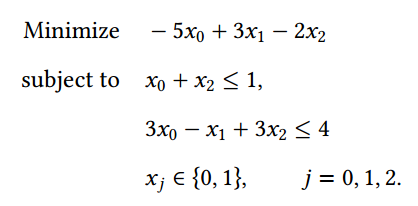

In [27]:
qubo = QuadraticProgram()
qubo.binary_var('x_0')
qubo.binary_var('x_1')
qubo.binary_var('x_2')

#Defining QUBO
qubo.minimize(linear=[-5, 3, -2])
qubo.linear_constraint(linear=[1, 1], sense="LE", rhs=1, name="first_constraint")
qubo.linear_constraint(linear=[3, -1, 3], sense="LE", rhs=4, name="second_constraint")

print(qubo.prettyprint())

Problem name: 

Minimize
  -5*x_0 + 3*x_1 - 2*x_2

Subject to
  Linear constraints (2)
    x_0 + x_1 <= 1  'first_constraint'
    3*x_0 - x_1 + 3*x_2 <= 4  'second_constraint'

  Binary variables (3)
    x_0 x_1 x_2



Now we need to convert the inequalitys to equations. We can do this simply adding slack variables in the constraints. The first one is $first\_constraint@int\_slack \leq 1$, witch is simply $y_0$ in binary. The second one is $second\_constraint@int\_slack \leq 5$, witch is simply $y_0 + 2y_1 + 2y_2$. There is a qiskit library that does this conversion:

In [28]:
ineq2eq = InequalityToEquality()
qubo_equation = ineq2eq.convert(qubo)
print(qubo_equation.prettyprint())

Problem name: 

Minimize
  -5*x_0 + 3*x_1 - 2*x_2

Subject to
  Linear constraints (2)
    first_constraint@int_slack + x_0 + x_1 == 1  'first_constraint'
    second_constraint@int_slack + 3*x_0 - x_1 + 3*x_2 == 4  'second_constraint'

  Integer variables (2)
    0 <= first_constraint@int_slack <= 1
    0 <= second_constraint@int_slack <= 5

  Binary variables (3)
    x_0 x_1 x_2



Now we need to turn it into an equation that we can convert to the Ising model. First we need to convert the slack variable into binary variables, then apply penalty terms that do not violate the constrains - B = 11 in our case. 

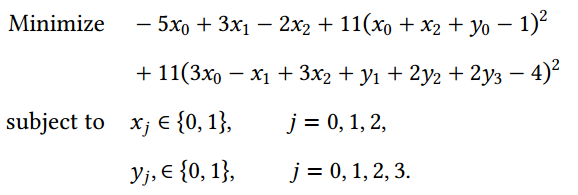

We can do this automatically using a qiskit library:

In [30]:
qubo_constraint = QuadraticProgramToQubo().convert(qubo_equation)
print(qubo_constraint.prettyprint())

Problem name: 

Minimize
  11*first_constraint@int_slack@0^2 + 11*second_constraint@int_slack@0^2
  + 44*second_constraint@int_slack@0*second_constraint@int_slack@1
  + 44*second_constraint@int_slack@0*second_constraint@int_slack@2
  + 44*second_constraint@int_slack@1^2
  + 88*second_constraint@int_slack@1*second_constraint@int_slack@2
  + 44*second_constraint@int_slack@2^2 + 22*x_0*first_constraint@int_slack@0
  + 66*x_0*second_constraint@int_slack@0 + 132*x_0*second_constraint@int_slack@1
  + 132*x_0*second_constraint@int_slack@2 + 110*x_0^2 - 44*x_0*x_1 + 198*x_0*x_2
  + 22*x_1*first_constraint@int_slack@0 - 22*x_1*second_constraint@int_slack@0
  - 44*x_1*second_constraint@int_slack@1 - 44*x_1*second_constraint@int_slack@2
  + 22*x_1^2 - 66*x_1*x_2 + 66*x_2*second_constraint@int_slack@0
  + 132*x_2*second_constraint@int_slack@1
  + 132*x_2*second_constraint@int_slack@2 + 99*x_2^2
  - 22*first_constraint@int_slack@0 - 88*second_constraint@int_slack@0
  - 176*second_constraint@int_sla

Now we can use the Ising model to compute the solution:

In [23]:
#QUBO to Ising
op, offset = qubo_constraint.to_ising()
print('offset: {}'.format(offset))
print('operator:')
print(op)

offset: 97.0
operator:
SparsePauliOp(['IIIIIIZ', 'IIIIIZI', 'IIIIZII', 'IIIZIII', 'IIZIIII', 'IZIIIII', 'ZIIIIII', 'IIIIIZZ', 'IIIIZIZ', 'IIIIZZI', 'IIIZIIZ', 'IIIZIZI', 'IIZIIIZ', 'IIZIIZI', 'IIZIZII', 'IZIIIIZ', 'IZIIIZI', 'IZIIZII', 'IZZIIII', 'ZIIIIIZ', 'ZIIIIZI', 'ZIIIZII', 'ZIZIIII', 'ZZIIIII'],
              coeffs=[-36. +0.j,   4. +0.j, -32. +0.j,  -5.5+0.j, -11. +0.j, -22. +0.j,
 -22. +0.j, -11. +0.j,  49.5+0.j, -16.5+0.j,   5.5+0.j,   5.5+0.j,
  16.5+0.j,  -5.5+0.j,  16.5+0.j,  33. +0.j, -11. +0.j,  33. +0.j,
  11. +0.j,  33. +0.j, -11. +0.j,  33. +0.j,  11. +0.j,  22. +0.j])


In [34]:
# Número de qubits
num_qubits = 7
expected_value = []
binary_str = []

for i in range(2**num_qubits):
    #Decimal to Binary
    binary_str.append(bin(i)[2:].zfill(num_qubits))  
    state = Statevector.from_int(i, dims = 2**num_qubits)
    #Computing the expected value using the formal definition
    expected_value.append(state.inner(state.evolve(op)))
    print("The expected value of state |{}> is".format(binary_str[i]), (expected_value[i]).real)
    
#Posições com o menor valor
max_cut = np.where(expected_value == np.min(expected_value))[0]

for i in range(len(max_cut)):
    print(' \n Therefore, the optimal solution is |{}>'.format(binary_str[max_cut[i]]))

The expected value of state |0000000> is 90.0
The expected value of state |0000001> is -91.0
The expected value of state |0000010> is 181.0
The expected value of state |0000011> is -44.0
The expected value of state |0000100> is -77.0
The expected value of state |0000101> is -60.0
The expected value of state |0000110> is -52.0
The expected value of state |0000111> is -79.0
The expected value of state |0001000> is 79.0
The expected value of state |0001001> is -80.0
The expected value of state |0001010> is 192.0
The expected value of state |0001011> is -11.0
The expected value of state |0001100> is -88.0
The expected value of state |0001101> is -49.0
The expected value of state |0001110> is -41.0
The expected value of state |0001111> is -46.0
The expected value of state |0010000> is 13.0
The expected value of state |0010001> is -102.0
The expected value of state |0010010> is 82.0
The expected value of state |0010011> is -77.0
The expected value of state |0010100> is -88.0
The expected val

Thefore, the optimal solution is $x_1=x_2=x_3=y_0=y_2=y_3=0$, $x_0=y_1=1$. And the QUBO minimization that obey the constrains is -5.

## The Knapsack problem

In the famous Knapsack problem, you are given a list of objects $j=0,..,m$, each of them with a weight $w_j$ and a value $c_j$. You are also given a maximum weight W and the goal is to nd a collection of objects that maximizes the total value without going over the maximum weight allowed. Think of it as if you were going on a journey and you want to pack as many valuable objects as possible without getting a knapsack that is too heavy to carry.

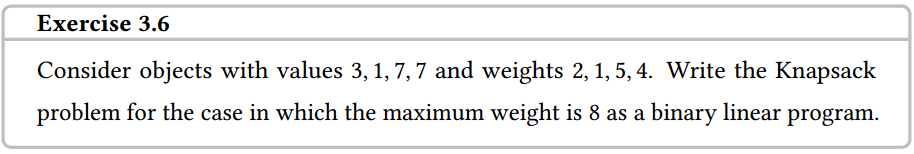

The problem can be formulated as


\begin{equation}
    Minimize \ \ \ \ \ \ \ \ -3x_0 -1x_1 - 7x_2 - 7x_3 \\
    subject \ to \ \ \ \ \ \ \ \ \ 2x_0 + 1x_1 + 5x_2 + 4x_3 \leq 8
\end{equation}

adding slack variables

\begin{equation}
    Minimize \ \ \ \ \ \ \ \ -3x_0 -1x_1 - 7x_2 - 7x_3 \\
    subject \ to \ \ \ \ \ \ \ \ \ 2x_0 + 1x_1 + 5x_2 + 4x_3 + y_0 + 2y_1 + 4y_2 + y_3= 8
\end{equation}

 Incorporating the constraints as penalty terms:


\begin{equation}
    Minimize \ \ \ \ \  -3x_0 -1x_1 - 7x_2 - 7x_3 \\ + 26(2x_0 + 1x_1 + 5x_2 + 4x_3 + y_0 + 2y_1 + 4y_2 + y_3)^2
\end{equation}

In [9]:
qubo = QuadraticProgram()
qubo.binary_var('x_0')
qubo.binary_var('x_1')
qubo.binary_var('x_2')
qubo.binary_var('x_3')

#Defining QUBO
qubo.minimize(linear=[-3, -1, -7, -7])
qubo.linear_constraint(linear=[2, 1, 5, 4], sense="LE", rhs=8, name="weight")

print(qubo.prettyprint())

Problem name: 

Minimize
  -3*x_0 - x_1 - 7*x_2 - 7*x_3

Subject to
  Linear constraints (1)
    2*x_0 + x_1 + 5*x_2 + 4*x_3 <= 8  'weight'

  Binary variables (4)
    x_0 x_1 x_2 x_3



In [10]:
ineq2eq = InequalityToEquality()
qubo_equation = ineq2eq.convert(qubo)
print(qubo_equation.prettyprint())

Problem name: 

Minimize
  -3*x_0 - x_1 - 7*x_2 - 7*x_3

Subject to
  Linear constraints (1)
    weight@int_slack + 2*x_0 + x_1 + 5*x_2 + 4*x_3 == 8  'weight'

  Integer variables (1)
    0 <= weight@int_slack <= 8

  Binary variables (4)
    x_0 x_1 x_2 x_3



In [11]:
qubo_constraint = QuadraticProgramToQubo().convert(qubo_equation)
print(qubo_constraint.prettyprint())

Problem name: 

Minimize
  19*weight@int_slack@0^2 + 76*weight@int_slack@0*weight@int_slack@1
  + 152*weight@int_slack@0*weight@int_slack@2
  + 38*weight@int_slack@0*weight@int_slack@3 + 76*weight@int_slack@1^2
  + 304*weight@int_slack@1*weight@int_slack@2
  + 76*weight@int_slack@1*weight@int_slack@3 + 304*weight@int_slack@2^2
  + 152*weight@int_slack@2*weight@int_slack@3 + 19*weight@int_slack@3^2
  + 76*x_0*weight@int_slack@0 + 152*x_0*weight@int_slack@1
  + 304*x_0*weight@int_slack@2 + 76*x_0*weight@int_slack@3 + 76*x_0^2
  + 76*x_0*x_1 + 380*x_0*x_2 + 304*x_0*x_3 + 38*x_1*weight@int_slack@0
  + 76*x_1*weight@int_slack@1 + 152*x_1*weight@int_slack@2
  + 38*x_1*weight@int_slack@3 + 19*x_1^2 + 190*x_1*x_2 + 152*x_1*x_3
  + 190*x_2*weight@int_slack@0 + 380*x_2*weight@int_slack@1
  + 760*x_2*weight@int_slack@2 + 190*x_2*weight@int_slack@3 + 475*x_2^2
  + 760*x_2*x_3 + 152*x_3*weight@int_slack@0 + 304*x_3*weight@int_slack@1
  + 608*x_3*weight@int_slack@2 + 152*x_3*weight@int_slack@3 + 304

In [12]:
#QUBO to Ising
op, offset = qubo_constraint.to_ising()
print('offset: {}'.format(offset))
print('operator:')
print(op)

offset: 390.0
operator:
SparsePauliOp(['IIIIIIIZ', 'IIIIIIZI', 'IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII', 'IIIIIIZZ', 'IIIIIZIZ', 'IIIIIZZI', 'IIIIZIIZ', 'IIIIZIZI', 'IIIIZZII', 'IIIZIIIZ', 'IIIZIIZI', 'IIIZIZII', 'IIIZZIII', 'IIZIIIIZ', 'IIZIIIZI', 'IIZIIZII', 'IIZIZIII', 'IIZZIIII', 'IZIIIIIZ', 'IZIIIIZI', 'IZIIIZII', 'IZIIZIII', 'IZIZIIII', 'IZZIIIII', 'ZIIIIIIZ', 'ZIIIIIZI', 'ZIIIIZII', 'ZIIIZIII', 'ZIIZIIII', 'ZIZIIIII', 'ZZIIIIII'],
              coeffs=[ -74.5+0.j,  -37.5+0.j, -186.5+0.j, -148.5+0.j,  -38. +0.j,  -76. +0.j,
 -152. +0.j,  -38. +0.j,   19. +0.j,   95. +0.j,   47.5+0.j,   76. +0.j,
   38. +0.j,  190. +0.j,   19. +0.j,    9.5+0.j,   47.5+0.j,   38. +0.j,
   38. +0.j,   19. +0.j,   95. +0.j,   76. +0.j,   19. +0.j,   76. +0.j,
   38. +0.j,  190. +0.j,  152. +0.j,   38. +0.j,   76. +0.j,   19. +0.j,
    9.5+0.j,   47.5+0.j,   38. +0.j,    9.5+0.j,   19. +0.j,   38. +0.j])


In [14]:
num_qubits = 8
expected_value = []
binary_str = []

for i in range(2**num_qubits):
    #Decimal to Binary
    binary_str.append(bin(i)[2:].zfill(num_qubits))  
    state = Statevector.from_int(i, dims = 2**num_qubits)
    #Computing the expected value using the formal definition
    expected_value.append(state.inner(state.evolve(op)))
    print("The expected value of state |{}> is".format(binary_str[i]), (expected_value[i]).real)
    
#Posições com o menor valor
max_cut = np.where(expected_value == np.min(expected_value))[0]

for i in range(len(max_cut)):
    print(' \n Therefore, the optimal solution is |{}>'.format(binary_str[max_cut[i]]))

The expected value of state |00000000> is 826.0
The expected value of state |00000001> is 291.0
The expected value of state |00000010> is 540.0
The expected value of state |00000011> is 81.0
The expected value of state |00000100> is -226.0
The expected value of state |00000101> is -381.0
The expected value of state |00000110> is -322.0
The expected value of state |00000111> is -401.0
The expected value of state |00001000> is -93.0
The expected value of state |00001001> is -324.0
The expected value of state |00001010> is -227.0
The expected value of state |00001011> is -382.0
The expected value of state |00001100> is -385.0
The expected value of state |00001101> is -236.0
The expected value of state |00001110> is -329.0
The expected value of state |00001111> is -104.0
The expected value of state |00010000> is 541.0
The expected value of state |00010001> is 82.0
The expected value of state |00010010> is 293.0
The expected value of state |00010011> is -90.0
The expected value of state |00

Therefore, the optmal solutions are $x_0=x_1=x_2 = 1$, $x_3 = 0$, or $x_0 = x_1 = x_3 = 1$, $x_2=0$.

## Graph Coloring

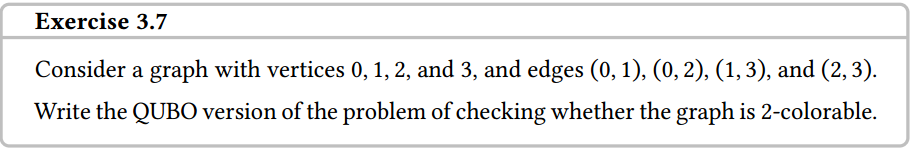

The problem can be formulated as:

\begin{equation}
Minimize \ \ \ \ \ \ \ \ \ (x_{00} + x_{01} -1)^2 + (x_{10} + x_{11} - 1)
+ (x_{20} + x_{21} - 1)^2 + (x_{30} + x_{31} - 1)^2  + x_{00}x_{10}
+ x_{01}x_{11} + x_{00}x_{20} + x_{01}x_{21} + x_{10}x_{30} 
+ x_{11}x_{31} + x_{20}x_{30} + x_{21}x_{31}
\end{equation}
 
Notice the constraints are already in QUBO to be minimized.

In [17]:
qubo = QuadraticProgram()
qubo.binary_var('x_0')
qubo.binary_var('x_1')
qubo.binary_var('x_2')
qubo.binary_var('x_3')
qubo.binary_var('x_4')
qubo.binary_var('x_5')
qubo.binary_var('x_6')
qubo.binary_var('x_7')

#Defining QUBO
qubo.minimize(quadratic={('x_0', 'x_0'):1, ('x_1', 'x_1'):1, 
                         ('x_2', 'x_2'):1, ('x_3', 'x_3'):1,
                         ('x_0', 'x_1'):2, ('x_1', 'x_3'):2,
                         ('x_4', 'x_5'):2, ('x_6', 'x_7'):2,
                         ('x_0', 'x_2'):1, ('x_1', 'x_3'):1,
                         ('x_0', 'x_4'):1, ('x_1', 'x_5'):1,
                         ('x_2', 'x_5'):1, ('x_3', 'x_7'):1,
                         ('x_4', 'x_6'):1, ('x_5', 'x_7'):1},
              linear=[-2, -2, -2, -2, -2, -2, -2, -2])


print(qubo.prettyprint())

Problem name: 

Minimize
  x_0^2 + 2*x_0*x_1 + x_0*x_2 + x_0*x_4 + x_1^2 + x_1*x_3 + x_1*x_5 + x_2^2
  + x_2*x_5 + x_3^2 + x_3*x_7 + 2*x_4*x_5 + x_4*x_6 + x_5*x_7 + 2*x_6*x_7
  - 2*x_0 - 2*x_1 - 2*x_2 - 2*x_3 - 2*x_4 - 2*x_5 - 2*x_6 - 2*x_7

Subject to
  No constraints

  Binary variables (8)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7



In [19]:
#QUBO to Ising
op, offset = qubo.to_ising()
print('offset: {}'.format(offset))
print('operator:')
print(op)

offset: -2.5
operator:
SparsePauliOp(['IIIIIIIZ', 'IIIIIIZI', 'IIZIIIII', 'IZIIIIII', 'IIIIIIZZ', 'IIIIIZIZ', 'IIIIZIZI', 'IIIZIIIZ', 'IIZIIIZI', 'IIZIIZII', 'IIZZIIII', 'IZIZIIII', 'ZIIIZIII', 'ZIZIIIII', 'ZZIIIIII'],
              coeffs=[-0.5 +0.j, -0.5 +0.j, -0.25+0.j,  0.25+0.j,  0.5 +0.j,  0.25+0.j,
  0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j,  0.5 +0.j,  0.25+0.j,
  0.25+0.j,  0.25+0.j,  0.5 +0.j])


In [20]:
# Número de qubits
num_qubits = 8
expected_value = []
binary_str = []

for i in range(2**num_qubits):
    #Decimal to Binary
    binary_str.append(bin(i)[2:].zfill(num_qubits))  
    state = Statevector.from_int(i, dims = 2**num_qubits)
    #Computing the expected value using the formal definition
    expected_value.append(state.inner(state.evolve(op)))
    print("The expected value of state |{}> is".format(binary_str[i]), (expected_value[i]).real)
    
#Posições com o menor valor
max_cut = np.where(expected_value == np.min(expected_value))[0]

for i in range(len(max_cut)):
    print(' \n Therefore, the optimal solution is |{}>'.format(binary_str[max_cut[i]]))

The expected value of state |00000000> is 2.5
The expected value of state |00000001> is 1.5
The expected value of state |00000010> is 1.5
The expected value of state |00000011> is 2.5
The expected value of state |00000100> is 1.5
The expected value of state |00000101> is 1.5
The expected value of state |00000110> is 0.5
The expected value of state |00000111> is 2.5
The expected value of state |00001000> is 1.5
The expected value of state |00001001> is 0.5
The expected value of state |00001010> is 1.5
The expected value of state |00001011> is 2.5
The expected value of state |00001100> is 0.5
The expected value of state |00001101> is 0.5
The expected value of state |00001110> is 0.5
The expected value of state |00001111> is 2.5
The expected value of state |00010000> is 0.5
The expected value of state |00010001> is 0.5
The expected value of state |00010010> is -0.5
The expected value of state |00010011> is 1.5
The expected value of state |00010100> is -0.5
The expected value of state |000

Therefore, the solution is

V_0 = V_3 = 1, V_1 = V_2 = 0.

V_0 = V_3 = 0, V_1 = V_2 = 1.

What means the problem is 2-colorable!